### Fonctions utiles 

In [2]:
#%% SECTION 1 inclusion de packages externes 


import numpy as np
import platform
import tempfile
import os
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
# necessite scikit-image 
from skimage import io as skio


#%% SECTION 2 fonctions utiles pour le TP

def viewimage(im,normalise=True,MINI=0.0, MAXI=255.0):
    """ Cette fonction fait afficher l'image EN NIVEAUX DE GRIS 
        dans gimp. Si un gimp est deja ouvert il est utilise.
        Par defaut normalise=True. Et dans ce cas l'image est normalisee 
        entre 0 et 255 avant d'être sauvegardee.
        Si normalise=False MINI et MAXI seront mis a 0 et 255 dans l'image resultat
        
    """
    imt=np.float32(im.copy())
    if platform.system()=='Darwin': #on est sous mac
        prephrase='open -a GIMP '
        endphrase=' ' 
    elif platform.system()=='Windows': 
        #ou windows ; probleme : il faut fermer gimp pour reprendre la main; 
        #si vous savez comment faire (commande start ?) je suis preneur 
        prephrase='"C:/Program Files/GIMP 2/bin/gimp-2.10.exe" '
        endphrase=' '
    else: #SINON ON SUPPOSE LINUX (si vous avez un windows je ne sais pas comment faire. Si vous savez dites-moi.)
        prephrase='gimp '
        endphrase= ' &'
    
    if normalise:
        m=im.min()
        imt=imt-m
        M=imt.max()
        if M>0:
            imt=imt/M

    else:
        imt=(imt-MINI)/(MAXI-MINI)
        imt[imt<0]=0
        imt[imt>1]=1
    
    nomfichier=tempfile.mktemp('TPIMA.png')
    commande=prephrase +nomfichier+endphrase
    skio.imsave(nomfichier,imt)
    os.system(commande)

def viewimage_color(im,normalise=True,MINI=0.0, MAXI=255.0):
    """ Cette fonction fait afficher l'image EN NIVEAUX DE GRIS 
        dans gimp. Si un gimp est deja ouvert il est utilise.
        Par defaut normalise=True. Et dans ce cas l'image est normalisee 
        entre 0 et 255 avant d'être sauvegardee.
        Si normalise=False MINI(defaut 0) et MAXI (defaut 255) seront mis a 0 et 255 dans l'image resultat
        
    """
    imt=np.float32(im.copy())
    if platform.system()=='Darwin': #on est sous mac
        prephrase='open -a GIMP '
        endphrase= ' '
    elif platform.system()=='Windows': 
        #ou windows ; probleme : il faut fermer gimp pour reprendre la main; 
        #si vous savez comment faire (commande start ?) je suis preneur 
        prephrase='"C:/Program Files/GIMP 2/bin/gimp-2.10.exe" '
        endphrase=' '
    else: #SINON ON SUPPOSE LINUX (si vous avez un windows je ne sais comment faire. Si vous savez dites-moi.)
        prephrase='gimp '
        endphrase=' &'
    
    if normalise:
        m=imt.min()
        imt=imt-m
        M=imt.max()
        if M>0:
            imt=imt/M
    else:
        imt=(imt-MINI)/(MAXI-MINI)
        imt[imt<0]=0
        imt[imt>1]=1
    
    nomfichier=tempfile.mktemp('TPIMA.pgm')
    commande=prephrase +nomfichier+endphrase
    skio.imsave(nomfichier,imt)
    os.system(commande)

def noise(im,br):
    """ Cette fonction ajoute un bruit blanc gaussier d'ecart type br
       a l'image im et renvoie le resultat"""
    imt=np.float32(im.copy())
    sh=imt.shape
    bruit=br*np.random.randn(*sh)
    imt=imt+bruit
    return imt

def quantize(im,n=2):
    """
    Renvoie une version quantifiee de l'image sur n (=2 par defaut) niveaux  
    """
    imt=np.float32(im.copy())
    if np.floor(n)!= n or n<2:
        raise Exception("La valeur de n n'est pas bonne dans quantize")
    else:
        m=imt.min()
        M=imt.max()
        imt=np.floor(n*((imt-m)/(M-m)))*(M-m)/n+m
        imt[imt==M]=M-(M-m)/n #cas des valeurs maximales
        return imt
    

def seuil(im,s):
    """ renvoie une image blanche(255) la ou im>=s et noire (0) ailleurs.
    """
    imt=np.float32(im.copy())
    mask=imt<s
    imt[mask]=0
    imt[~mask]=255
    return imt

def gradx(im):
    "renvoie le gradient dans la direction x"
    imt=np.float32(im)
    gx=0*imt
    gx[:,:-1]=imt[:,1:]-imt[:,:-1]
    return gx

def grady(im):
    "renvoie le gradient dans la direction y"
    imt=np.float32(im)
    gy=0*imt
    gy[:-1,:]=imt[1:,:]-imt[:-1,:]
    return gy

def view_spectre(im,option=1,hamming=False):
    """ affiche le spectre d'une image
     si option =1 on affiche l'intensite de maniere lineaire
     si option =2 on affiche le log
     si hamming=True (defaut False) alors une fenetre de hamming est appliquee avant de prendre la transformee de Fourier
     """
    imt=np.float32(im.copy())
    (ty,tx)=im.shape
    pi=np.pi
    if hamming:
        XX=np.ones((ty,1))@(np.arange(0,tx).reshape((1,tx)))
        YY=(np.arange(0,ty).reshape((ty,1)))@np.ones((1,tx))
        imt=(1-np.cos(2*pi*XX/(tx-1)))*(1-np.cos(2*pi*YY/(ty-1)))*imt
    aft=np.fft.fftshift(abs(np.fft.fft2(imt)))
    
    if option==1:
        viewimage(aft)
    else:
        viewimage(np.log(0.1+aft))


def filterlow(im): 
    """applique un filtre passe-bas parfait a une image (taille paire)"""
    (ty,tx)=im.shape
    imt=np.float32(im.copy())
    pi=np.pi
    XX=np.concatenate((np.arange(0,tx/2+1),np.arange(-tx/2+1,0)))
    XX=np.ones((ty,1))@(XX.reshape((1,tx)))
    
    YY=np.concatenate((np.arange(0,ty/2+1),np.arange(-ty/2+1,0)))
    YY=(YY.reshape((ty,1)))@np.ones((1,tx))
    mask=(abs(XX)<tx/4) & (abs(YY)<ty/4)
    imtf=np.fft.fft2(imt)
    imtf[~mask]=0
    return np.real(np.fft.ifft2(imtf))

def filtergauss(im):
    """applique un filtre passe-bas gaussien. coupe approximativement a f0/4"""
    (ty,tx)=im.shape
    imt=np.float32(im.copy())
    pi=np.pi
    XX=np.concatenate((np.arange(0,tx/2+1),np.arange(-tx/2+1,0)))
    XX=np.ones((ty,1))@(XX.reshape((1,tx)))
    
    YY=np.concatenate((np.arange(0,ty/2+1),np.arange(-ty/2+1,0)))
    YY=(YY.reshape((ty,1)))@np.ones((1,tx))
    # C'est une gaussienne, dont la moyenne est choisie de sorte que
    # l'integrale soit la meme que celle du filtre passe bas
    # (2*pi*sig^2=1/4*x*y (on a suppose que tx=ty))
    sig=(tx*ty)**0.5/2/(pi**0.5)
    mask=np.exp(-(XX**2+YY**2)/2/sig**2)
    imtf=np.fft.fft2(imt)*mask
    return np.real(np.fft.ifft2(imtf))
#%% SECTION 3 exemples de commandes pour effectuer ce qui est demande pendant le TP
    

In [44]:
#%% charger une image + visualiser sur gimp

# marche pour tif et png :

# en tif :
im=skio.imread('images/lena.tif')

# visualiser l'image (elle en niveaux de gris)
viewimage(im)

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


### 1) Propriétés de base 

In [45]:
# connaitre la taille de l'image
im.shape

(512, 512)

In [46]:
#avoir la valeur d'un pixel
im[9,8] #pixel en y=9 et x=8

# avec l'outil pointeur, situé dans Fenêtres => Fenêtres ancrables => Pointeur 
# on peut vérifier que le pixel x= 8 et y=9, a une valeur de 130

135

In [ ]:
# Vérification des axes x et y :
im[498,49]

In [ ]:
im[49,489] 

In [ ]:
im = skio.imread('images/lena.tif')
plt.imshow(im)
plt.plot(49,489,'+r') # plot "inverse les x et les y" comparé à im[] : plot(49,489) == im[498,49]
plt.plot(489,49,'+y')

In [ ]:
# par exemple on affiche la ligne y=129
plt.plot(im[129,:])

In [ ]:
r=im.reshape( (-1,)) # équivalent à im.reshape(-1)
r.shape

### 2.1)  Zooms

In [ ]:
im=skio.imread('images/lena.tif')
viewimage(im)


im_petit =skio.imread('images/lena_petit.tif')
viewimage(im_petit)

En zoomant, et en comaprant lena_petit et lena_zoom_2, 
j'observe que l'image lena_petit contient moins de details que l'image lena_zoom_2.

Les contours sont plus lisses, les détails du chapeau moins visibles, 
j'en déduis que l'image lena_petit a été obtenu par une réductio nde l'image lena mais avec une interpolation,
lissant les détails.



### 2.2) Espace couleurs 

In [34]:
#%% une image couleur 
im=skio.imread('images/fleur.tif')
viewimage_color(im,normalise=False) #on ne normalise pas pour garder l'image comme
                                    # a l'origine
im.shape

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


(562, 604, 3)

In [36]:
# voir un seul canal (rouge)
viewimage(im[:,:,0]) # on regarde (562,604) pixels sur le canal R de l'image RGB

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


On observe que les fleurs blanches ou jaunes sont de valeur 255 car le Jaune saturé vaut (255,255,0) en rgb
les pixels des fleurs rouges, elles, ont une valeur élevés si elles sont rouge clair, plus petite sinon
Les fleurs rouges sont grisées car leur valeur en en rgb sont de la forme : (xxx,0,0)
similairement à une image en niveaux de gris de 0 à 255.

Transformer les fleurs jaunes en fleurs bleues : 
    en sélectionnant le jauen comme couleur à changer, si on pousse sa teinte à +180 ou -180, 
    les fleurs jaunes apparaissent bleues : on a changé la référence du jaune dans l'mage pour en faire du bleu
    
Très bien, cela marche pour les fleurs parmi les 6 couleurs proposées, mais qu'en est-il pour les fleurs violettes par exemple ?

En manipulant les curseurs Bleu et Cyan, on remarque que les fleurs sont composées d'une partie Bleu et d'une partie Cyan
    On peut donc supposer que la valeur rgb de chaque pixel est affecté à une des 6 catégories, et que modifier la teinte d'une     couleur va modifier tous les pixels dans cette catégorie.
    
A noter que certains pixels ne changent pas de teinte, alors qu'à l'oeil on pourrait dire qu'ils sont jaune foncé par exemple, je suppsoe que ces pixels ne sont pas affectés par le changement en jaune car ils ne sont plus dans la fourchette des couleur "jaune", étant donné que leur valeur est faible pour le jaune, ils sont trop sombres pour rentrer dans la catégorie Jaune

La saturation correspond à l'éclat des couleurs :
par exemple l'ensemble des fleurs jaunes sont de la forme ( X,  X, Y), cad avec des valeurs en rouge et vert égalent
La saturation permet de modifier l'éclat du jaune de l'image, pour le rendre très "jaune" de la forme (255,255,0) avec une saturation de 100%
ou terne, de la forme (m,m,m) où m est la moyenne de la valeur du pixel avec une saturations de -100% : attention on aura pas un noir mais un gris 

In [37]:
viewimage(im.mean(axis=2)) #la moyenne des trois canaux

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


### Histogramme 

(array([1.100e+01, 6.500e+01, 1.110e+02, 1.640e+02, 2.610e+02, 3.080e+02,
        4.310e+02, 5.370e+02, 6.820e+02, 8.460e+02, 9.120e+02, 1.074e+03,
        1.349e+03, 1.480e+03, 1.681e+03, 1.620e+03, 2.064e+03, 1.835e+03,
        2.048e+03, 1.989e+03, 1.911e+03, 2.257e+03, 2.129e+03, 1.748e+03,
        1.776e+03, 0.000e+00, 1.850e+03, 1.688e+03, 1.605e+03, 1.661e+03,
        1.355e+03, 1.360e+03, 1.188e+03, 1.278e+03, 1.062e+03, 1.027e+03,
        1.052e+03, 1.084e+03, 1.013e+03, 1.026e+03, 9.150e+02, 9.260e+02,
        1.029e+03, 1.014e+03, 1.023e+03, 8.750e+02, 1.110e+03, 1.057e+03,
        8.620e+02, 1.120e+03, 0.000e+00, 9.270e+02, 1.073e+03, 1.069e+03,
        1.004e+03, 1.275e+03, 1.274e+03, 1.129e+03, 1.266e+03, 1.495e+03,
        1.548e+03, 1.591e+03, 2.046e+03, 1.706e+03, 1.998e+03, 1.704e+03,
        2.022e+03, 1.705e+03, 1.801e+03, 1.674e+03, 1.766e+03, 1.594e+03,
        1.711e+03, 1.474e+03, 1.491e+03, 1.566e+03, 0.000e+00, 1.456e+03,
        1.445e+03, 1.524e+03, 1.371e+0

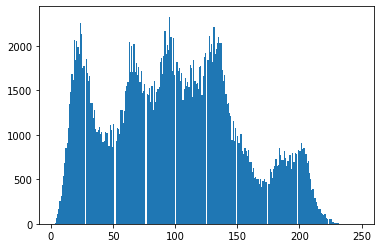

In [62]:
# simple visualisation de l'histogramme
im=skio.imread('images/lena.tif')

plt.hist(im.reshape((-1,)),bins=255) #le reshape transforme en tableau 1D

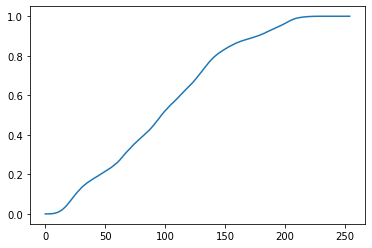

In [42]:
#calcul d'un histogramme cumulé
(histo,bins)=np.histogram(im.reshape((-1,)),np.arange(0,256)) #le reshape est inutile pour np.histogram, mais on le laisse pour la compatibilite avec plt.hist
histo=histo/histo.sum()
histocum=histo.cumsum()
plt.plot(histocum)

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


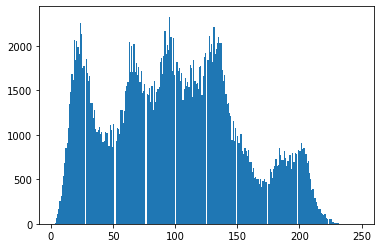

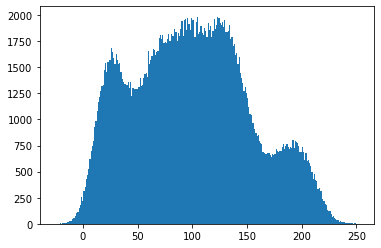

In [53]:
# ajout de bruit, déformation de l'histogramme
imbr=noise(im,10) #10 est l'ecart type 
viewimage_color(imbr,normalise=False)
#effet sur l'histogramme
plt.hist(im.reshape((-1,)),255)
plt.show()
plt.hist(imbr.reshape((-1,)),255)
plt.show()

l'ajout de bruit tend à faire disparaitre les pics centraux, qui ne sont plus discernables.
les 2 pics extremaux se sont étalés, notamment dans la direction vers le centre.

Si on considère els niveaux de gris comme la réalisation d'une variable aléatoire d'une image, dont la loi est l'histogramme, 
Ajouter du bruit revient à convoluer l'histogramem de base avec une fonction gaussien, ce qui donnerait l'histogramme buité, dont les hauts et bas seraient rapprochés.

Les niveux de gris tendent vers l'histogramme de la loi gaussienne, quand l'écart type du bruit augmente 

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


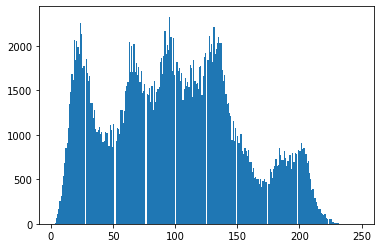

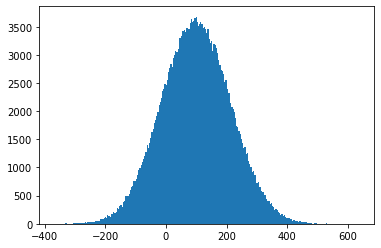

In [54]:
#%% ajout d'énormément de bruit, histogramme gaussien  
imbr=noise(im,100)
viewimage_color(imbr,normalise=False)
#effet sur l'histogramme
plt.hist(im.reshape((-1,)),255)
plt.show()
plt.hist(imbr.reshape((-1,)),255)
plt.show()

### 3.2) Changement de contraste 



Si on change la fonction linéaire par d'autres fonctions croissantes, comme une fonction convex ou une fonction concave, on observe toujours la même scène : les niveaux de gris sont modifiés mais cohérent par rapport à l'image de base

Par contre, si la transformation est non croissante, certaines parties avant sombres sont devenus plus claires que certaines zones moyennement sombres. La scène est grandement chnagée par rapport à l'image de base.


La fonction contraste est équivalente à l'effet d'une fonction d'erreur, à la place de la fonction linéaire dans l'outil Courbes: en effet les zones sombres sont assombries et les zones calires sont éclaircies

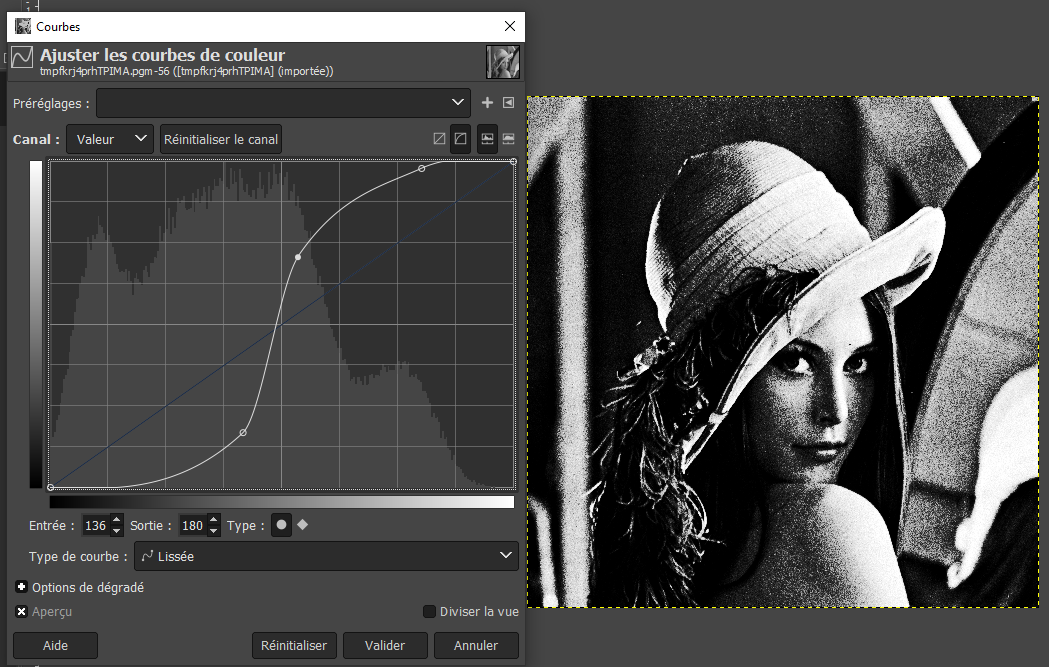


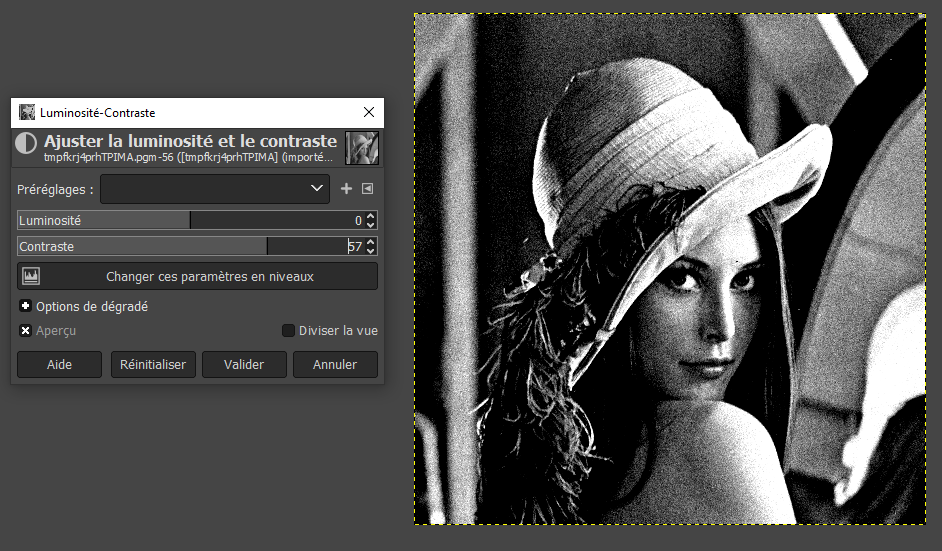

### 3.3) Egalisation d'histogramme

In [3]:
# Prise de vue d'une image sombre 
im=skio.imread('images/sombre.jpg')
im=im.mean(axis=2) #on est sur que l'image est grise
viewimage(im)

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


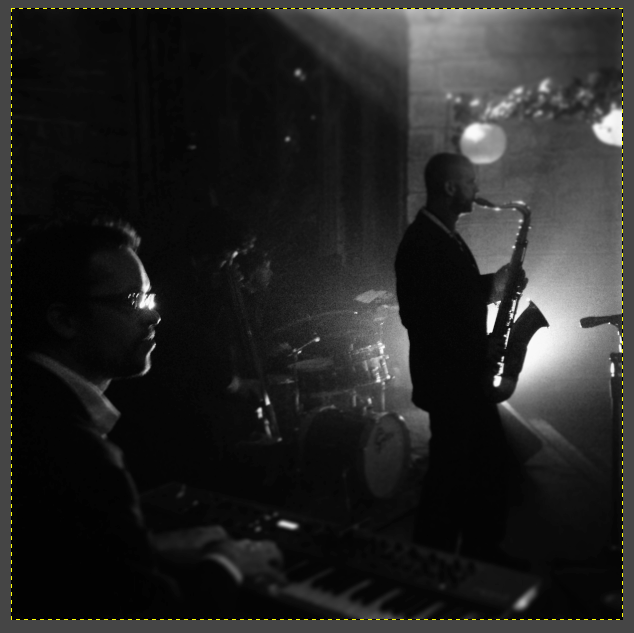

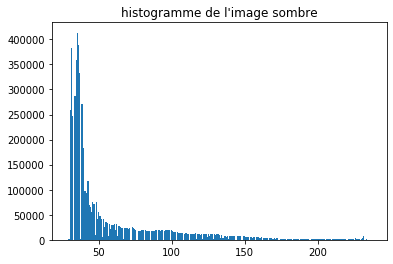

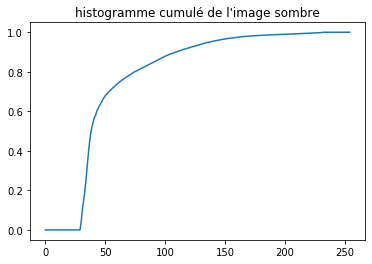

In [8]:
# calcul de l'histogramme et de l'histogramme cumulé 
plt.hist(im.reshape((-1,)),255)
plt.title("histogramme de l'image sombre")
plt.show()


(histo,bins)=np.histogram(im.reshape((-1,)),np.arange(0,256)) 
histo=histo/histo.sum()
histocum=histo.cumsum()
plt.plot(histocum)
plt.title("histogramme cumulé de l'image sombre")
plt.show()

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


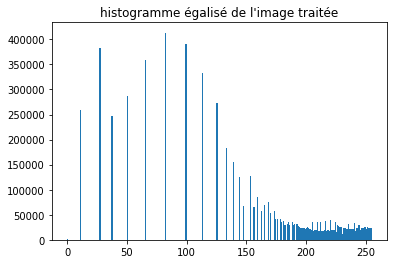

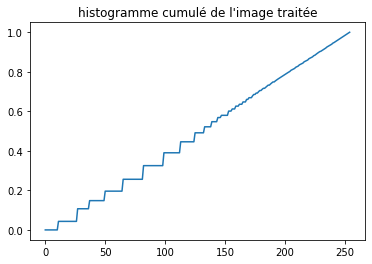

In [16]:
# égalisation d'histogramme 
imequal=histocum[np.uint8(im)]*255 # on multiplie par 255 car histocumm a des valeurs entre 0 et 1
viewimage(imequal)

plt.hist(imequal.reshape((-1,)),255)
plt.title("histogramme égalisé de l'image traitée")
plt.show()

(histo,bins)=np.histogram(imequal.reshape((-1,)),np.arange(0,256)) #le reshape est inutile pour np.histogram, mais on le laisse pour la compatibilite avec plt.hist
histo=histo/histo.sum()
histocum_2=histo.cumsum()
plt.plot(histocum_2)
plt.title("histogramme cumulé de l'image traitée")
plt.show()

L'image obtenue contient bien plus de détails que l'imaeg originale, elle est mieux contrastée :
on remarque les voutes au fond, le sol aussi parait mieux discernable 

mais on peut aussi argumenter que l'image parait plus "bruitée": les costumes des musiciens ne sont plus d'un noir profond, mais constellés de points gris

On observe un espacement de la répartition des pixels sur toute la palge [0,255]

L'histogramme cumulé quant à lui est proche d'uen fonction linéaire. C'est ce  à quoi on s'attendait en répartissant uniformément l'histogramme sur toute la plage de [0,255]. Les marches que l'on voit sont dû à la discretisation du problème, et aussi au fait que les pixels à valeurs dans chaque pic de la plage [0,155] sont très nombreux, donc ces pics sont éloignés, alors que les pixels à valeurs dans [200,255] par exemple sont moins nombreux à chaque pic, donc ces pics sont très proches.

L'esapcement entre les pics est proportionnelle au nombre de pixels dans ce pic, afin d'avoir un étalement de l'histogramme.

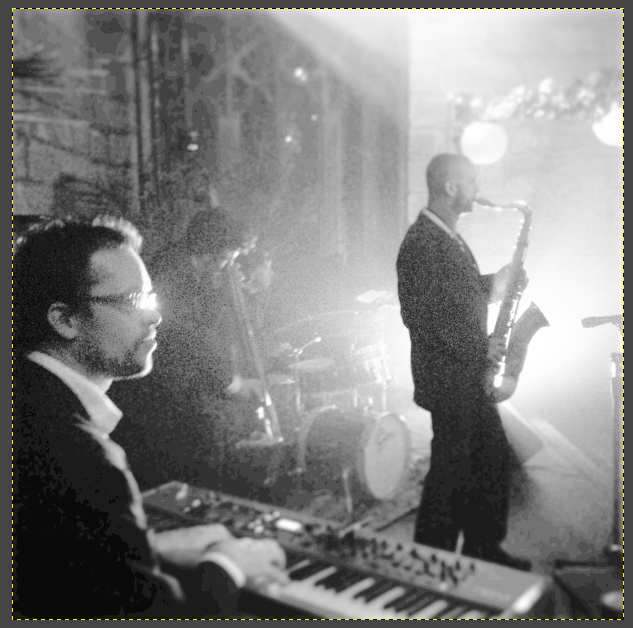

### 3.4) Prescription d'histogramme

In [4]:
# visulation des 2 prises de vue 

u=skio.imread('images/vue1.tif')
v=skio.imread('images/vue2.tif')
viewimage(u)
viewimage(v)

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [8]:
# Donner à une image u l'histogramme de l'image v 

ushape=u.shape
uligne=u.reshape((-1,)) #transforme en ligne
vligne=v.reshape((-1,))
ind=np.argsort(uligne)
unew=np.zeros(uligne.shape,uligne.dtype)
unew[ind]=np.sort(vligne)
# on remet a la bonne taille
unew=unew.reshape(ushape)
viewimage(unew)

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [15]:
#Valeur absolue de la différence entre les 2 images 

image_difference = abs(u - v)
viewimage(image_difference)

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Dans la différences entre les 2 images, on remarque plusieurs choses interessantes :

1) Les points saturés sur les 2 images ont une différence de 0, ce sont les zones noires de la lampe par exemple

2) L'apparition d'artefact, des points saturés mais je ne comprends pas d'où ils proviennent : 
il n'y a pas de points saturé à 255 dans une image et qui sont à 0 dans l'autre, alors pq autant de points blancs ? 

Ce phénomène apparait dans les zones très sombres, comme si 0 dans u - 0 dans v donner parfois 255...

Par exempel dans le pied de latable avec beaucoup de points chauds, les pixels ont une valeur d'environ 15 dans l'image éclairée et 4 dans l'autre, comment se fait-il que la différence affichée soit de 255 ?

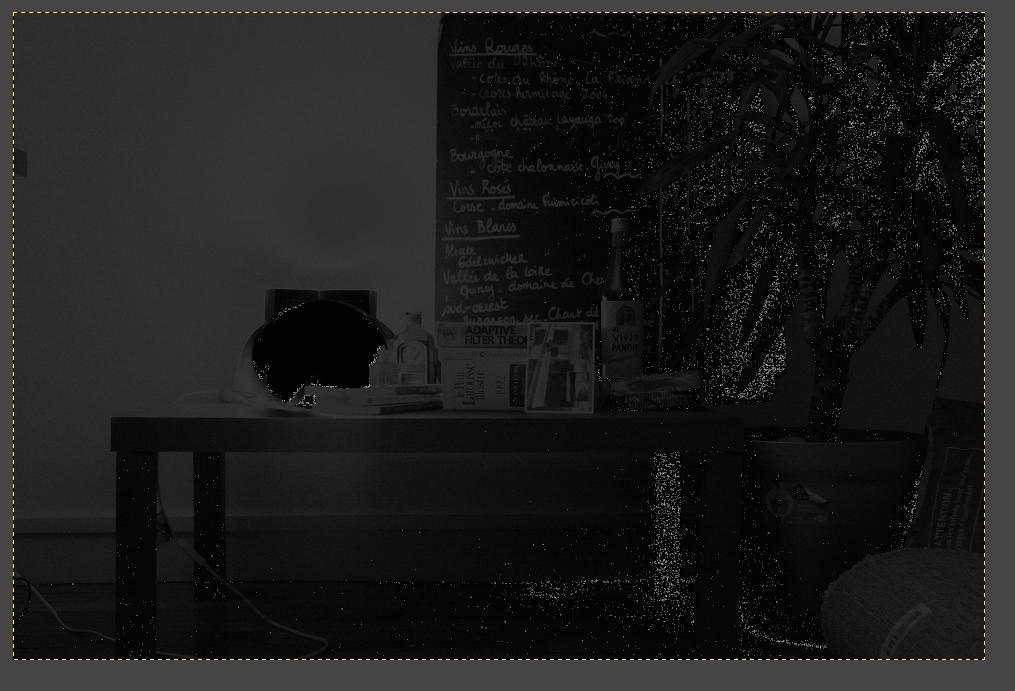

In [7]:
#Valeur absolue de la différence entre les unew et v 
image_difference_2 = abs(unew - v)
viewimage(image_difference_2)

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


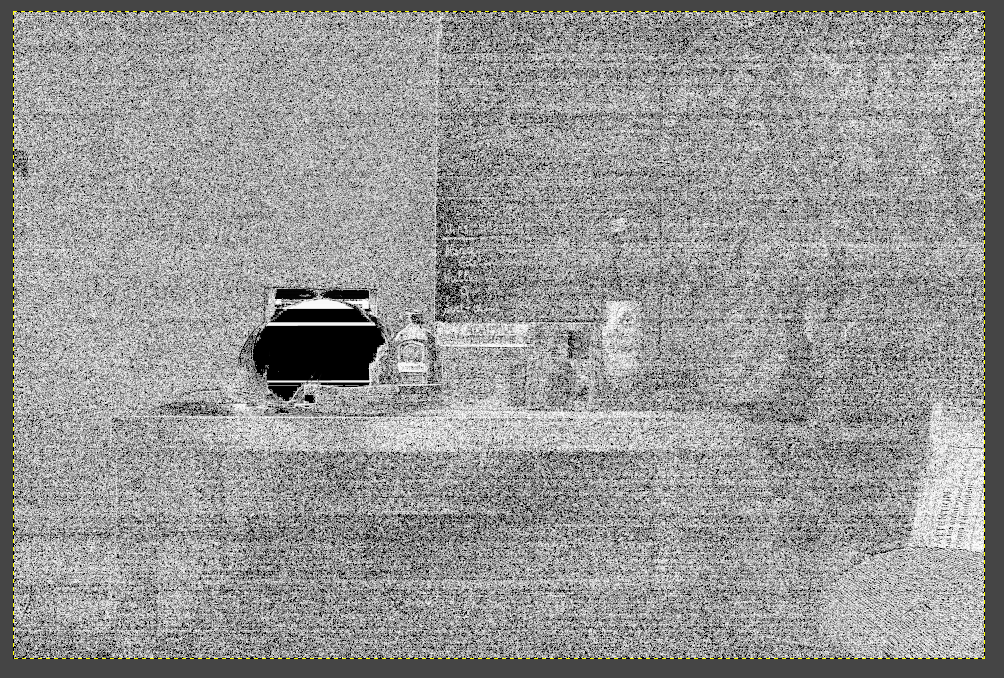

Quand on fait la différence de l'image u modifiée avec l'histogramme de l'image v avec l'image v, 
on observe énormément de "points chauds", où la différence entre les 2 images est de 255.
Pourtant l'image unew et v sont très similaires visuellement. 
Je ne saurais expliquer l'origine de l'apparition de ce bruit dans leur différence ...
Modifier la valeur des pixels en passant par l'histogramme induirait du bruit ? Cela me surprend au vu des opérations "simples" que nous faisons, il ne s'agit que de remettre les valeurs d'une matrice dans un ordre différent 

Pour donner le même histogramme aux 2 images, puisque seul change le temps d'exposition, on pourrait translater l'histogramme vers la gauche pour assombrir l'image ou vers la droite pour l'éclaircir.

### 3.5) Dithering (détramage)

In [87]:
# visualisation de l'image de travail
im=skio.imread('images/lena.tif')
im2=quantize(im,4)
viewimage(im2)

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [89]:
# seuillage à la valeur 128
viewimage(seuil(im,128))

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


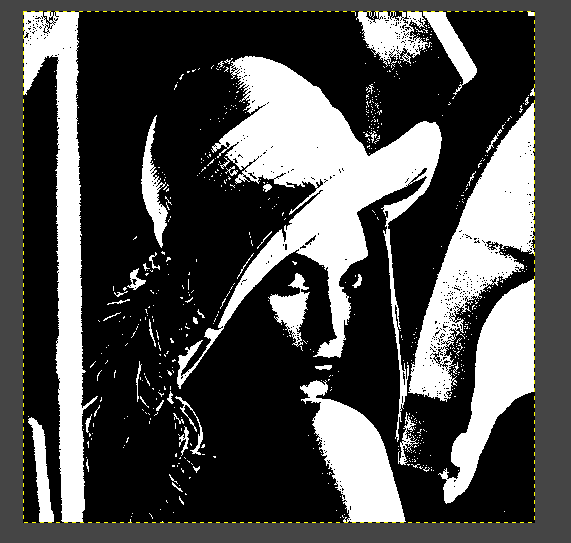

In [88]:
# ajout de bruit puis seuillage 

viewimage(seuil(noise(im,40),128)) #exemple de dithering

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


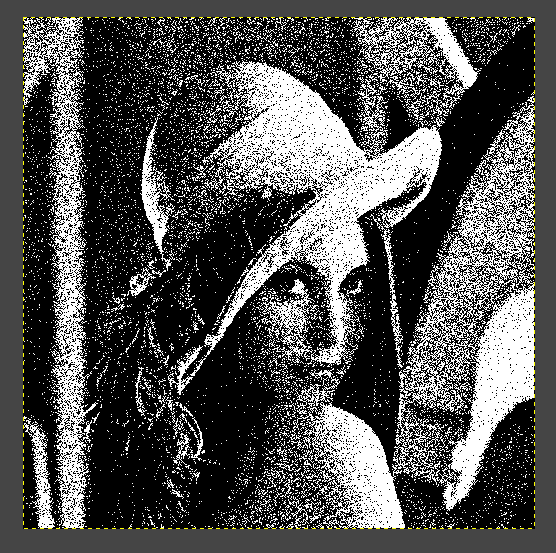

On observe qu'avec le meme seuil, on obtient beacoup plus de détails dans l'image bruitée puis seuillée, 
Le dithering parait donné une image plus proche de l'image réelle, elle a comme avantage de laisser passer au dessus du seuil de nombreux points dans des zones à la frontière avec le seuil.

la propabilité qu'un pixel soit blanc, sachant que sa valeur est de a additionné à un bruit n avec un seuil de \lamnbda, est :

$ \int_{\lambda - a}^{+ \infty} g(x) dx $ où g(x) suit une loi Gaussienne centré en 0, de std = bruit gaussien

###   3.6) Différence de niveaux de gris voisins 

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


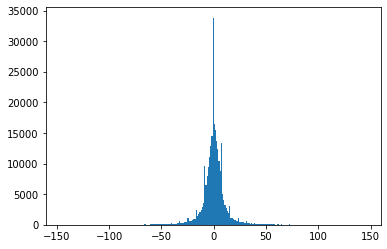

In [9]:
# visualisation d'une différence sur l'axe horizontale et son histogramme
im_grad_x = gradx(im)
viewimage(im_grad_x)

plt.hist(im_grad_x.reshape((-1,)),255)
plt.show()

In [15]:
from math import *
(histo,bins)=np.histogram(im_grad_x.reshape((-1,)),np.arange(0,256))
histo_shape = histo.shape

C:\Spyder\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


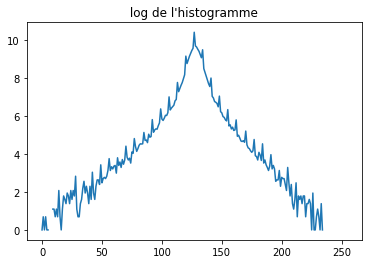

In [23]:
# log d'un histogramme
plt.plot(np.log(np.histogram(gradx(im),255)[0]))
plt.title(" log de l'histogramme ")
plt.show()

Je pense que la répartition de l'histogramme suit une loi gaussienne, car la probabilité d'avoir une contraste sur une image est totalement aléatoire, car on peut considérer chaque image comme une réalisation d'une répartiton aléatoire de pixels.

La loi de répartition des différences des pixels tendrait donc vers une loi normale.

### 4.1 Visualisation de spectres

In [24]:
im=skio.imread('images/lena.tif')
view_spectre(im,option=1,hamming=True)

C:\Spyder\lib\site-packages\ipykernel_launcher.py:51: UserWarning: C:\Users\NEEBOL~1\AppData\Local\Temp\tmprb9kfpj9TPIMA.png is a low contrast image
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [32]:
im=skio.imread('images/lena.tif')
view_spectre(im,option=2,hamming=True)

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [33]:
im=skio.imread('images/lena.tif')
view_spectre(im,option=2,hamming=False)

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


l'option 2 permet de mieux voir le spectre, en effet c'est le logarithme du spectre qui affiché,
ce qui permet d'atténuer le point central qui est extrêmement brillant par rapport aux autres composantes du spectre.

Ajouter de hamming permet de s'affranchir de la taille de l'image, qui ajoute des lignes verticales à cause du caractère carré de l'image.

Il vaut mieux travailler avec le hamming = True, pour n'avoir que le spectre de l'image, sans l'influence de la dimension finie de celle-ci. On peut faire un parallèle avec la TF d'un signal, qui est en fait la TF de la Porte d'un signal, il faut veiller à ce que la porte aie une forme qui n'influence pas sur le spectre du final

In [34]:
im=skio.imread('images/rayures.tif')
view_spectre(im,option=2,hamming=False)

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


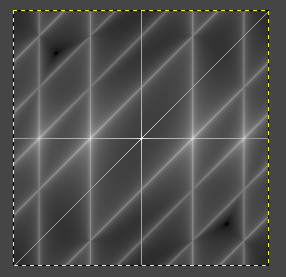

In [47]:
im=skio.imread('images/rayures.tif')
view_spectre(im,option=2,hamming=True)

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


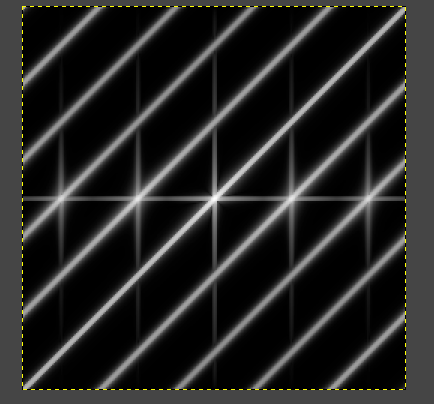

Oui on peut retrouver les caractéristique de l'image dans son spectre :

Par exemple nous avons des traits verticaux tous les 50 pixels en x, cela nous informe qu'il y a des traits verticaux sur l'image et qu'il sont de fréquence 50.
Il y a donc 50 bandes verticales sur l'image rayure.tif

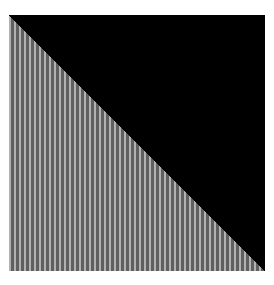

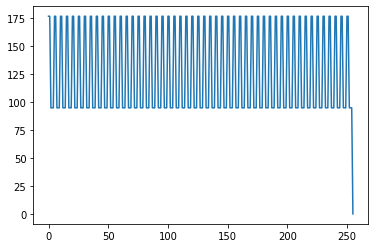

In [48]:
# En étudiant la derniere ligne 
plt.plot(im[255,:])

In [60]:
counter = 0
for k,elem in enumerate(im[255,:]):
    if elem == max(im[255,:]) and im[255,:][k-1]!= max(im[255,:]): # il faut compter le nombre de pics distincts
        counter += 1 
counter

51